<a href="https://colab.research.google.com/github/ExplorerGumel/Trailblazers-Qualification-Challenge/blob/main/Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import numpy as np
from os.path import join
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit,KFold
from sklearn.ensemble import AdaBoostRegressor,ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans


In [8]:
train=pd.read_csv("/content/Train.csv")
test=pd.read_csv("/content/Test.csv")
ss=pd.read_csv("/content/SampleSubmission.csv")
#variable_definition=pd.read_csv("/content/variable_descriptions.csv")

In [9]:
train.head()

,ward,total_households,total_individuals,target,dw_00,dw_01,dw_02,dw_03,dw_04,dw_05,...,pw_03,pw_04,pw_05,pw_06,pw_07,pw_08,ADM4_PCODE,lat,lon,NL
0,41601001: Ward 1,1674.45058,5888.20750,16.773757,0.933841,0.000846,0.005490,0.000676,0.000000,0.001372,...,0.002848,0.007537,0.000000,0.012928,0,0,ZA4161001,-29.682270,24.734743,0.292039
1,41601002: Ward 2,1736.99230,6735.33812,21.496661,0.696940,0.001253,0.004402,0.000000,0.002301,0.001323,...,0.014566,0.057127,0.019092,0.004131,0,0,ZA4161002,-29.119311,24.757737,3.207775
2,41601003: Ward 3,2403.57591,7273.04995,10.931425,0.810545,0.004517,0.008891,0.003986,0.007735,0.000956,...,0.057560,0.010358,0.001421,0.040881,0,0,ZA4161003,-29.142276,25.094093,0.000000
3,41601004: Ward 4,1740.78737,5734.49046,23.119257,0.659914,0.000000,0.006129,0.000000,0.000813,0.037245,...,0.000000,0.000669,0.000000,0.005011,0,0,ZA4161004,-29.372052,24.942867,2.038778
4,41601005: Ward 5,1730.51451,6657.23835,13.652252,0.950575,0.000655,0.001473,0.000598,0.006999,0.000818,...,0.004859,0.001290,0.000673,0.017629,0,0,ZA4161005,-29.409381,25.290165,0.000000


In [10]:
## Join train and test datasets inorder to perform preprocessing once at a time

Full_data = pd.concat([train,test],0)
print("Full_data shape : ",Full_data.shape)


## total_households and total individual has a very high values ranges than all others.To avoid skewness,let's scale them to range
# 1 to -1 and later on drop the unscaled ones
Full_data['Family'] = Full_data['total_individuals'] / Full_data['total_households']

mm = MinMaxScaler()

Full_data['scaled_total_households'] = mm.fit_transform(Full_data['total_households'].values.reshape(-1,1))
Full_data  = Full_data.drop('total_households', axis=1)
Full_data['scaled_total_individuals'] = mm.fit_transform(Full_data['total_individuals'].values.reshape(-1,1))
Full_data  = Full_data.drop('total_individuals', axis=1)
Full_data.head()

Full_data shape :  (3835, 63)


,ward,target,dw_00,dw_01,dw_02,dw_03,dw_04,dw_05,dw_06,dw_07,...,pw_06,pw_07,pw_08,ADM4_PCODE,lat,lon,NL,Family,scaled_total_households,scaled_total_individuals
0,41601001: Ward 1,16.773757,0.933841,0.000846,0.005490,0.000676,0.000000,0.001372,0.005750,0.031466,...,0.012928,0.0,0.0,ZA4161001,-29.682270,24.734743,0.292039,3.516501,0.042169,0.060514
1,41601002: Ward 2,21.496661,0.696940,0.001253,0.004402,0.000000,0.002301,0.001323,0.007575,0.123547,...,0.004131,0.0,0.0,ZA4161002,-29.119311,24.757737,3.207775,3.877587,0.043745,0.069786
2,41601003: Ward 3,10.931425,0.810545,0.004517,0.008891,0.003986,0.007735,0.000956,0.006686,0.022632,...,0.040881,0.0,0.0,ZA4161003,-29.142276,25.094093,0.000000,3.025929,0.060543,0.075672
3,41601004: Ward 4,23.119257,0.659914,0.000000,0.006129,0.000000,0.000813,0.037245,0.005255,0.068909,...,0.005011,0.0,0.0,ZA4161004,-29.372052,24.942867,2.038778,3.294194,0.043841,0.058831
4,41601005: Ward 5,13.652252,0.950575,0.000655,0.001473,0.000598,0.006999,0.000818,0.004985,0.009150,...,0.017629,0.0,0.0,ZA4161005,-29.409381,25.290165,0.000000,3.846971,0.043582,0.068931


In [12]:
## Feature extraction

#Based on the features given, we extract worst cases(Those with no access to water,no landline,lived in caravan/tent, e.t.c)
#while best case otherwise

Full_data['Worst_case'] = Full_data['pw_06']+Full_data['lln_01']+Full_data['dw_10']+Full_data['psa_01']+Full_data['car_01']+Full_data['stv_00']
Full_data['Best_case'] = Full_data['pw_00']+Full_data['lln_00']+Full_data['dw_00']+Full_data['psa_00']+Full_data['car_00']+Full_data['stv_01']

Full_data.head()

,ward,target,dw_00,dw_01,dw_02,dw_03,dw_04,dw_05,dw_06,dw_07,...,pw_08,ADM4_PCODE,lat,lon,NL,Family,scaled_total_households,scaled_total_individuals,Worst_case,Best_case
0,41601001: Ward 1,16.773757,0.933841,0.000846,0.005490,0.000676,0.000000,0.001372,0.005750,0.031466,...,0.0,ZA4161001,-29.682270,24.734743,0.292039,3.516501,0.042169,0.060514,2.513173,3.045809
1,41601002: Ward 2,21.496661,0.696940,0.001253,0.004402,0.000000,0.002301,0.001323,0.007575,0.123547,...,0.0,ZA4161002,-29.119311,24.757737,3.207775,3.877587,0.043745,0.069786,2.447272,2.404363
2,41601003: Ward 3,10.931425,0.810545,0.004517,0.008891,0.003986,0.007735,0.000956,0.006686,0.022632,...,0.0,ZA4161003,-29.142276,25.094093,0.000000,3.025929,0.060543,0.075672,2.511429,2.526830
3,41601004: Ward 4,23.119257,0.659914,0.000000,0.006129,0.000000,0.000813,0.037245,0.005255,0.068909,...,0.0,ZA4161004,-29.372052,24.942867,2.038778,3.294194,0.043841,0.058831,2.529029,2.687843
4,41601005: Ward 5,13.652252,0.950575,0.000655,0.001473,0.000598,0.006999,0.000818,0.004985,0.009150,...,0.0,ZA4161005,-29.409381,25.290165,0.000000,3.846971,0.043582,0.068931,2.343123,3.110453


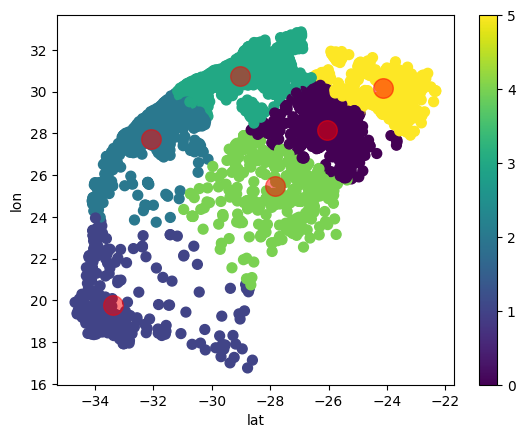

In [13]:
# Let use kmeans to cluster based on the lattitude and longitude 

kmeans = KMeans(n_clusters =6, init ='k-means++')
kmeans.fit(Full_data[['lat','lon']])
Full_data['cluster_label'] = kmeans.fit_predict(Full_data[['lat','lon']])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.labels_
Full_data.plot.scatter(x = 'lat', y = 'lon', c=labels, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='r', s=200, alpha=0.5)

In [14]:
columns=Full_data.drop(["ward","target","ADM4_PCODE"],1).columns
columns

Index(['dw_00', 'dw_01', 'dw_02', 'dw_03', 'dw_04', 'dw_05', 'dw_06', 'dw_07',
       'dw_08', 'dw_09', 'dw_10', 'dw_11', 'dw_12', 'dw_13', 'psa_00',
       'psa_01', 'psa_02', 'psa_03', 'psa_04', 'stv_00', 'stv_01', 'car_00',
       'car_01', 'lln_00', 'lln_01', 'lan_00', 'lan_01', 'lan_02', 'lan_03',
       'lan_04', 'lan_05', 'lan_06', 'lan_07', 'lan_08', 'lan_09', 'lan_10',
       'lan_11', 'lan_12', 'lan_13', 'lan_14', 'pg_00', 'pg_01', 'pg_02',
       'pg_03', 'pg_04', 'lgt_00', 'pw_00', 'pw_01', 'pw_02', 'pw_03', 'pw_04',
       'pw_05', 'pw_06', 'pw_07', 'pw_08', 'lat', 'lon', 'NL', 'Family',
       'scaled_total_households', 'scaled_total_individuals', 'Worst_case',
       'Best_case', 'cluster_label'],
      dtype='object')

In [ ]:
columns=Full_data.drop(["ward","target","ADM4_PCODE"],1).columns
data_km=Full_data[columns].copy()
km=KMeans(10,random_state=2019)
Full_data["cluster"]=km.fit_predict(data_km[columns])
Full_data["cluster"].value_counts()

4    1250
9     744
3     444
2     323
8     305
7     294
0     262
6     113
5      99
1       1
Name: cluster, dtype: int64

In [18]:

Full_data['W'] = LabelEncoder().fit_transform(Full_data['ward'])
Full_data['car_01_bin'] = Full_data['car_01'].apply(lambda x : np.round(x * 100) ) 
Full_data['psa_01_bin'] = Full_data['psa_01'].apply(lambda x : np.round(x * 100) ) 
Full_data['stv_01_bin'] = Full_data['stv_01'].apply(lambda x : np.round(x * 100) ) 
Full_data['W_encoded1'] = Full_data.groupby('W')['psa_01_bin'].transform('mean')
Full_data['W_encoded2'] = Full_data.groupby('W')['car_01_bin'].transform('mean')
Full_data['W_encoded3'] = Full_data.groupby('W')['stv_01_bin'].transform('mean')
Full_data = Full_data.drop(['W','car_01_bin','psa_01_bin','stv_01_bin'],1)

In [20]:

Full_data['Cluster_label_encoded'] = Full_data.groupby('cluster_label')['target'].transform('mean')

train_set = Full_data[Full_data.target.notnull()]
test_set = Full_data[Full_data.target.isnull()]


In [21]:
test_set=test_set.drop('target',axis=1)
test_set=test_set.drop(['ward','ADM4_PCODE' ],axis=1)
train_set=train_set.drop(['ward','ADM4_PCODE' ],axis=1)

In [25]:
train_set

,target,dw_00,dw_01,dw_02,dw_03,dw_04,dw_05,dw_06,dw_07,dw_08,...,Family,scaled_total_households,scaled_total_individuals,Worst_case,Best_case,cluster_label,W_encoded1,W_encoded2,W_encoded3,Cluster_label_encoded
0,16.773757,0.933841,0.000846,0.005490,0.000676,0.000000,0.001372,0.005750,0.031466,0.008080,...,3.516501,0.042169,0.060514,2.513173,3.045809,4,53.984925,77.160804,81.105528,22.153095
1,21.496661,0.696940,0.001253,0.004402,0.000000,0.002301,0.001323,0.007575,0.123547,0.151910,...,3.877587,0.043745,0.069786,2.447272,2.404363,4,53.447236,76.417085,80.271357,22.153095
2,10.931425,0.810545,0.004517,0.008891,0.003986,0.007735,0.000956,0.006686,0.022632,0.129902,...,3.025929,0.060543,0.075672,2.511429,2.526830,4,53.824121,75.100503,78.974874,22.153095
3,23.119257,0.659914,0.000000,0.006129,0.000000,0.000813,0.037245,0.005255,0.068909,0.218786,...,3.294194,0.043841,0.058831,2.529029,2.687843,4,53.517588,76.100503,78.889447,22.153095
4,13.652252,0.950575,0.000655,0.001473,0.000598,0.006999,0.000818,0.004985,0.009150,0.015382,...,3.846971,0.043582,0.068931,2.343123,3.110453,4,52.861878,75.314917,78.756906,22.153095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2817,6.393480,0.874972,0.003146,0.017230,0.004735,0.048888,0.000654,0.017798,0.005539,0.010383,...,3.541599,0.082166,0.122505,2.311651,3.289393,4,53.984925,77.160804,81.105528,22.153095
2818,15.668000,0.636235,0.002262,0.010433,0.000000,0.003030,0.000000,0.008028,0.095099,0.210044,...,5.405712,0.036843,0.082632,2.427999,2.487853,4,53.447236,76.417085,80.271357,22.153095
2819,13.238795,0.855975,0.006601,0.061118,0.000812,0.003912,0.000812,0.017205,0.036566,0.008099,...,4.474215,0.035132,0.064390,2.434193,2.865849,4,53.824121,75.100503,78.974874,22.153095
2820,17.639523,0.792552,0.004423,0.016099,0.000000,0.000674,0.000000,0.006907,0.038522,0.116643,...,4.771611,0.042301,0.083791,2.502904,2.701088,4,53.517588,76.100503,78.889447,22.153095


In [110]:

feature_cols = [x for x in train_set.columns if x != 'target']

strat_shuff_split = KFold(n_splits=5)

train_idx,test_idx = next(strat_shuff_split.split(train_set[feature_cols],train_set['target']))

X_train = train_set.loc[train_idx,feature_cols]
y_train = train_set.loc[train_idx,'target']
X_test = train_set.loc[test_idx,feature_cols]
y_test = train_set.loc[test_idx,'target']

ada=AdaBoostRegressor(learning_rate=0.6282347769006077,n_estimators=263,random_state=42,estimator=LinearRegression())
ada.fit(X_train,y_train)
prediction=ada.predict(X_test)

print(mean_squared_error(y_test,prediction))

14.137956225819071
